# Stochastic Simulation

*Winter Semester 2024/25*

14.02.2025

Prof. Sebastian Krumscheid<br>
Assistants: Stjepan Salatovic, Louise Kluge

<h3 align="center">
Exercise sheet 13
</h3>

---

<h1 align="center">
Markov Chain Monte Carlo
</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy.stats import multivariate_normal
from typing import Literal
from tqdm.notebook import tqdm
from ipywidgets import interact

In [2]:
plt.rc('font', size=14)          # Controls default text sizes
plt.rc('axes', titlesize=16)     # Fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## Exercise 1

Consider the Random Walk Metropolis-Hastings (RWMH) algorithm with proposal density $q(x,y) = g_\sigma(y-x)$ and target density
$f\colon\mathbb{R}\to \mathbb{R}^+$.
Let $g_\sigma$ denote the density of the $\mathcal{N}(0,\sigma^2)$ distribution and suppose that
\begin{equation*}
f(y) =\frac{1}{Z} \exp{\biggl[-\biggl(\frac{1}{4}y^4-\frac{1}{2}y^2+\frac{1}{4}\biggr)\biggr]}\;,
\end{equation*}
where $Z$ is such that $f$ is a PDF on $\mathcal{X}=\mathbb{R}$. 
Suppose we wish to estimate $\mu = \mathbb{E}_f(\phi)$ for a suitable function $\phi\colon\mathbb{R}\to\mathbb{R}$. Let $\hat\mu_n^{\text{MH}}$ be the estimator for $\mu$ based on the Markov chain of length $n$ generated by the RWMH algorithm. 
Derive asymptotic confidence intervals for $\mu$ at probability level $\alpha$ using the CLT for Metropolis-Hastings Markov Chains. Within your simulations, estimate this confidence interval and stop the Markov chain once the half-length of the interval is smaller than a given tolerance $\tau>0$. The estimation has to be carried out on-the-fly, that is while the Markov chain evolves. Implement  the following heuristics to estimate the required _time-average variance constant_ (TAVC) and compare their performance for different functions $\phi$; namely $\phi(x) = x^p, p \in \mathbb{N}$.
The TAVC is the asymptotic variance introduced in Lemma 8.16 of the lecture notes.

1. **Initial positive sequence estimator:** \begin{equation*}
        \tilde\sigma^2 \approx \hat\sigma_{\text{pos},n}^2 :=
        \hat{c}_n(0) + 2\sum_{k=1}^K\bigl(\hat{c}_n(2k) + \hat{c}_n(2k+1) \bigr),
      \end{equation*}
      where $K$ is the largest integer such that
      $\hat{c}_n(2k) + \hat{c}_n(2k+1)>0$ for all $k=1,\dots,
      K$. Here,
      \begin{equation*}
        \hat{c}_n(k) := \frac{1}{n - k - 1}\sum_{i=1}^{n-k}\Bigl(\phi(X_i) - \hat\mu_n^{\text{MH}}\Bigr)\Bigl(\phi(X_{i+k}) - \hat\mu_n^{\text{MH}}\Bigr)
      \end{equation*}
      is an appropriate covariance estimator in this context.

2. **Initial monotone sequence estimator:** \begin{equation*}
        \tilde\sigma^2 \approx \hat\sigma_{\text{mon},n}^2 :=
        \hat{c}_n(0) + 2 \sum_{k=1}^K\min_{1\le j\le k}\bigl\{\hat{c}_n(2j) + \hat{c}_n(2j+1)\bigr\},
      \end{equation*}
      where $K$ and $\hat{c}_n$ are as for the initial
      positive sequence estimator above.

3. **Batch means estimator:** Suppose the Markov chain is
      $X_1,\dots, X_n$ at iteration $n$. Divide these $n$ values into
      $N_b\in\mathbb{N}$ batches, each of length $N_\ell = n/N_b$. A
      typical decomposition is $N_\ell = n^{1-a}$ and $N_b = n^a$ for
      $a\in[0,1]$, for example $a=0.5$, modulo integer rounding. Let
      \begin{equation*}
        \hat\mu_i =  \frac{1}{N_\ell} \sum_{j= (i-1)N_\ell + 1}^{iN_\ell}\phi(X_j)\;,\quad i=1,\dots, N_b\;,
      \end{equation*}
      be the sample mean of the $i$-th batch. For $N_\ell$
      sufficiently large, one can consider the batch means
      $\hat\mu_1, \hat\mu_2,\dots,\hat\mu_{N_b}$ to be approximately
      mutually independent. Consequently, one can estimate the time
      average variance constant $\sigma^2$ by the sample variance
      estimator for independent realizations:
      \begin{equation*}
        \tilde\sigma^2 \approx \hat\sigma_{\text{BM},n}^2 := \frac{N_l}{N_b-1}\sum_{i=1}^{N_b}{\bigl(\hat\mu_i-\hat\mu_n^{\text{MH}}\bigr)}^2\;.
      \end{equation*}

In addition, instead of using all of the points in the Markov chain, one can as well discard a burn-in time $B$ and replace $\sum_{k=1}$ with $\sum_{k=B}$ in the above estimators. 
Experiment with the effects of burn-in time on the above asymptotic variance estimators. 

In [10]:
def f(y: float) -> float:
    return np.exp(-(1/4 * y**4 - 1/2 * y**2 + 1/4))

In [11]:
def compute_covars(X: np.array) -> np.array:
    """
    Computes the autocovariance of a one-dimensional array.
    
    Args:
        X (np.array): A one-dimensional numpy array of numerical data.
    
    Returns:
        np.array: A one-dimensional numpy array containing the autocovariance values.
    """
    Xmean = X.mean()
    N = len(X)
    X_centered = X - Xmean
    cov = np.correlate(X_centered, X_centered, mode='full')[N+1:] / np.arange(N-2, 0, -1)
    return cov

In [12]:
def get_K(cov: np.array) -> int:
    """
    Determines the first index where the sum of adjacent autocovariance values becomes non-positive.

    Args:
        cov (np.array): A one-dimensional numpy array of autocovariance values.
    
    Returns:
        int: The index of the first non-positive sum of adjacent autocovariance values.
    """
    return np.argmin((cov[:-1] + cov[1:]) > 0)

In [13]:
def sigma_ipse(X: np.array) -> float:
    """
    Initial positive sequence estimator (IPSE).
    
    Args:
        X (np.array): A one-dimensional numpy array representing the Markov chain.
    
    Returns:
        float: The IPSE estimate of the variance.
    """
    cov = compute_covars(X)
    K = get_K(cov)
    sigma = cov[0] + 2 * (cov[:K][:-1] + cov[:K][1:]).sum()
    return sigma

In [14]:
def sigma_imse(X: np.array):
    """
    Initial monotone sequence estimator (IPSE).
    
    Args:
        X (np.array): A one-dimensional numpy array representing the Markov chain.
    
    Returns:
        float: The IMSE estimate of the variance.
    """
    cov = compute_covars(X)
    K = get_K(cov)
    sigma = cov[0] + 2 * np.minimum.accumulate(cov[:K][:-1] + cov[:K][1:]).sum()
    return sigma

In [15]:
def sigma_bm(X: np.array, a: float=0.5) -> float:
    """
    Batch means estimator (BM).
    
    Args:
        X (np.array): A one-dimensional numpy array representing the Markov chain.
        a (float, optional): The exponent used to determine the number of batches. Defaults to 0.5.
    
    Returns:
        float: The BM estimate of the variance.
    """
    n = len(X)
    Nb = int(n ** a) 
    Nl = int(n / Nb)
    batch_means = X[:Nb * Nl].reshape(Nb, Nl).mean(axis=1)
    sigma = Nl * np.var(batch_means, ddof=1)
    return sigma

In [16]:
def RWMH(
    sigma: float,
    tavc_est: Literal["IPS", "IMS", "BM"],
    alpha: float,
    tol: float,
    min_iter: int = 50,
    max_iter: int = 1000,
    burn_in: int = 0
)-> np.array:
    """
    Performs the Random Walk Metropolis-Hastings (RWMH) algorithm with adaptive stopping based on confidence interval width.

    Args:
        sigma (float): The standard deviation of the proposal distribution.
        tavc_est (Literal["IPS", "IMS", "BM"]): The method used for variance estimation. Must be one of "IPS", "IMS", or "BM".
        alpha (float): The significance level used in the confidence interval calculation.
        tol (float): The tolerance level for the width of the confidence interval. Sampling stops when the confidence interval width is below this threshold.
        min_iter (int, optional): The minimum number of iterations to perform before checking the stopping criterion. Defaults to 50.
        max_iter (int, optional): The maximum number of iterations to perform. Defaults to 1000.
        burn_in (int, optional): The number of initial samples to discard. Defaults to 0.
    
    Returns:
        np.array: An array of samples generated by the RWMH algorithm.
        list: A list of confidence interval widths for each iteration after the minimum number of iterations.
    """

    cval = norm.ppf(1 - alpha/2)
    cis = []

    X = np.zeros(max_iter)
    X[0] = np.random.randn()
    for i in tqdm(range(max_iter - 1)):
        Y = X[i] + sigma * np.random.randn()
        alpha = min(1, f(Y) / f(X[i]))
        if np.random.rand() < alpha:
            X[i + 1] = Y
        else:
            X[i + 1] = X[i]

        if i < min_iter:
            continue

        if tavc_est == "IPS":
            tavc = sigma_ipse(phi(X[:i]))
        elif tavc_est == "IMS":
            tavc = sigma_imse(phi(X[:i]))
        elif tavc_est == "BM":
            tavc = sigma_bm(phi(X[:i]))

        ci = cval * tavc / np.sqrt(i)
        cis.append(ci)

        if ci < tol:
            break
    
    return X[burn_in:i], cis

In [17]:
sigma = 4.0
alpha = 0.05
tol = 0.01

p = 2
phi = lambda x: x ** p

min_iter = 50
max_iter = 5_000

X_ips, ci_ips = RWMH(sigma, "IPS", alpha, tol, min_iter=min_iter, max_iter=max_iter)
X_ims, ci_ims = RWMH(sigma, "IMS", alpha, tol, min_iter=min_iter, max_iter=max_iter)
X_bm, ci_bm = RWMH(sigma, "BM", alpha, tol, min_iter=min_iter, max_iter=max_iter)

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

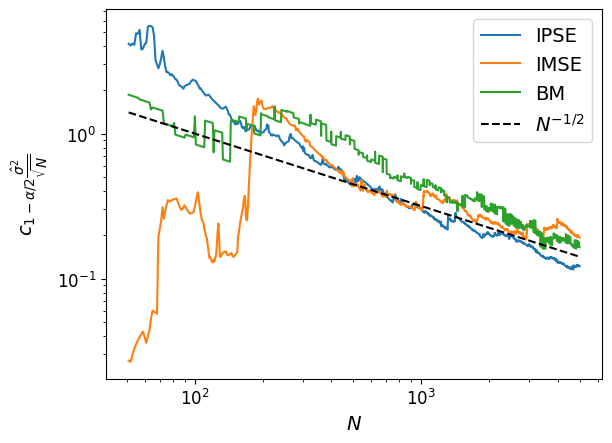

In [18]:
Ns = np.arange(min_iter + 1, max_iter)
plt.loglog(Ns, ci_ips, label="IPSE")
plt.loglog(Ns, ci_ims, label="IMSE")
plt.loglog(Ns, ci_bm, label="BM")
plt.loglog(Ns, 1e1 * Ns ** -0.5, "k--", label="$N^{-1 / 2}$")

plt.xlabel("$N$")
plt.ylabel(r"$c_{1 - \alpha / 2}\frac{\hat{\sigma}^2}{\sqrt{N}}$")
plt.legend();

## Exercise 2

Consider the following probability density function in $\mathbb{R}^2$, $\mathbf{x}=(x_1,x_2)^T\in\mathbb{R}^2$,
$$
f(\mathbf{x}) = \frac{1}{Z} \left[\exp\left\{-(1-x_1)^2 - (x_2-x_1^2)^2\right\}+\exp\left\{-(x_1+1)^2 - (x_2+3+x_1^2)^2 \right\}\right], 
$$
where $Z$ is the (unknown) normalization constant. To generate samples
from $f$, we consider Metropolis-Hastings (MH) type MCMC
algorithms. Let us denote with
$$
p(\mathbf{x};\mathbf{\mu},\Sigma)=\frac{1}{\sqrt{\operatorname{det}(2\pi\Sigma)}}e^{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu})}
$$
the pdf of a $\mathcal{N}(\mathbf{\mu},\Sigma)$ multivariate Gaussian random variable and by

- $K_1$, the Markov kernel associated to an _Independent
  Sampler_ MH algorithm with proposal density $q_1(\mathbf{x},\mathbf{y}) =
  \frac{1}{2}p(\mathbf{y};(1,1)^T,
  0.5\,I_{2\times2})+\frac{1}{2}p(\mathbf{y};(-1,-3)^T, 0.5\,I_{2\times2})$
- $K_2$, the Markov kernel associated to a _Random Walk_ MH
  algorithm with proposal density
  $q_2(\mathbf{x},\mathbf{y})=p(\mathbf{y};\mathbf{x},\sigma^2\,I_{2\times2})$ , where $\sigma=0.15.$

1. Write the explicit expression of the densities corresponding to the Markov kernels $K_1$ and $K_2$.

Let $q(\mathbf{x}, \mathbf{y})$, $q_1(\mathbf{x}, \mathbf{y})$ and $q_2(\mathbf{x}, \mathbf{y})$ be the densities corresponding to the transition kernels $K$, $K_1$ and $K_2$ respectively.
The MH density corresponding to $K_1$ reads:
\begin{align*}
p_1(\mathbf{x}, \mathbf{y}) &= \alpha_1(\mathbf{x}, \mathbf{y}) q_1(\mathbf{x}, \mathbf{y}) + \left[1 - \int \alpha_1(\mathbf{x}, \mathbf{y})q_1(\mathbf{x}, \mathbf{y}) d\mathbf{y} \right]\delta_{\mathbf{x}}(\mathbf{y}),\\
\text{where }\alpha_1(\mathbf{x}, \mathbf{y})& = \min \left\{1 , \frac{q_1(\mathbf{x}, \mathbf{y}) f(\mathbf{y})}{q_1(\mathbf{y}, \mathbf{x}) f(\mathbf{x})} \right\}
\end{align*}
and similarly for $K_2$.

2. Consider now the kernel $K(\omega) = \omega K_1+(1-\omega)K_2$, with $\omega\in [0,1]$. Show that $K(\omega)$ is a reversible Markov kernel that has $f$ as invariant distribution.

$K_1$ and $K_2$ are reversible.
Convex combinations of reversible kernels are also reversible:
\begin{align*}
f(\mathbf{x})K(\mathbf{x},\mathbf{y}) &= f(\mathbf{y})K(\mathbf{y},\mathbf{x})\\
\implies wf(\mathbf{x})K_1(\mathbf{x},\mathbf{y}) + (1-w)f(\mathbf{x})K_2(\mathbf{x},\mathbf{y}) &= wf(\mathbf{y})K_1(\mathbf{y},\mathbf{x}) + (1-w)f(\mathbf{y})K_2(\mathbf{y},\mathbf{x}),
\end{align*}
where we have used the reversibility of $K_1$ and $K_2$. 

3. Implement a MCMC algorithm that uses the Markov kernel $K(\omega)$ to estimate $\mathbb{E}_f[\|\mathbf{X}\|^2]$, with $\mathbf{X}=(X_1,X_2)^T\sim f$. 
Include the usual MCMC diagnostic plots in your experiment and describe how you would choose the sample size (length of the chain) to guarantee an error on the computation of $\mathbb{E}_f[\|\mathbf{X}\|^2]$ smaller than $\varepsilon=1$ with confidence at least $0.95$. 
Estimate also the expected acceptance rate $\chi(\omega)$ of the implemented algorithm. 
Try at least two different values for $\omega$.

    **Hint:** [`scipy.stats.multivariate_normal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)

In [3]:
def f(x: float, y: float) -> float:
    """
    Target distribution function.

    Args:
        x (float): The x-coordinate.
        y (float): The y-coordinate.

    Returns:
        float: The value of the function at (x, y).
    """
    return np.exp(-(1-x)**2 - (y-x**2)**2) + np.exp(-(1+x)**2 - (y+3+x**2)**2)

In [4]:
def K1(x: float, y: float) -> float:
    """
    First component of the mixture kernel.

    Args:
        x (float): The x-coordinate.
        y (float): The y-coordinate.

    Returns:
        float: The value of the first kernel component at (x, y).
    """
    return 0.5 * multivariate_normal.pdf([x, y], mean=(1, 1), cov=0.5*np.eye(2)) \
        + 0.5 * multivariate_normal.pdf([x, y], mean=(-1, -3), cov=0.5*np.eye(2))

In [5]:
def K2(x: float, y: float, xm: float, ym: float, sigma: float) -> float:
    """
    Second component of the mixture kernel.

    Args:
        x (float): The x-coordinate.
        y (float): The y-coordinate.
        xm (float): The mean x-coordinate of the kernel.
        ym (float): The mean y-coordinate of the kernel.
        sigma (float): The standard deviation of the kernel.

    Returns:
        float: The value of the second kernel component at (x, y).
    """
    return multivariate_normal.pdf([x, y], mean=(xm, ym), cov=sigma*np.eye(2))

In [6]:
def K(x: float, y: float, xm: float, ym: float, w: float, sigma: float) -> float:
    """
    Proposal distribution function.

    Args:
        x (float): The x-coordinate.
        y (float): The y-coordinate.
        xm (float): The mean x-coordinate of the proposal distribution.
        ym (float): The mean y-coordinate of the proposal distribution.
        w (float): The weight parameter.
        sigma (float): The standard deviation of the proposal distribution.

    Returns:
        float: The value of the proposal distribution at (x, y).
    """
    return w * K1(x, y) + (1-w) * K2(x, y, xm, ym, sigma)

In [7]:
def MCMC(w: float, sigma: float, N: int = 1000) -> np.array:
    """
    Implements the Metropolis-Hastings MCMC algorithm.

    Args:
        w (float): The weight parameter for the proposal distribution.
        sigma (float): The standard deviation of the proposal distribution.
        N (int, optional): The number of samples to generate. Defaults to 1000.

    Returns:
        np.array: An array of samples generated by the MCMC algorithm.
    """
    Xchain = np.zeros((N, 2))
    Xn = np.array([0, 0])
    Xchain[0] = Xn
    n_acc = 0

    for n in range(1, N):
        u1 = np.random.rand()
        if u1 <= w:
            u2 = np.random.rand()
            if u2 <= 0.5:
                Xnew = 1 + np.sqrt(0.5) * np.random.randn(2)
            else:
                Xnew = np.array([-1, -3]) + np.sqrt(0.5) * np.random.randn(2)
        else:
            Xnew = Xn + sigma * np.random.randn(2)

        ratio = f(*Xnew) * K(*Xn, *Xnew, w, sigma) / (f(*Xn) * K(*Xnew, *Xn, w, sigma))

        if np.random.rand() <= np.min([1, ratio]):
            Xn = Xnew
            n_acc += 1
        Xchain[n] = Xn

    acceptance_rate = n_acc / N
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    return Xchain

In [8]:
def plot_chain(w: float, N: int):
    """Interaction helper."""
    np.random.seed(999)
    sigma = 0.15
    Xchain = MCMC(w, sigma, N)

    x = np.linspace(-3, 3, 1000)
    y = np.linspace(-10, 7, 1000)
    X,Y = np.meshgrid(x,y)
    Z = f(X,Y)
    plt.contourf(X,Y,Z);
    plt.scatter(*Xchain.T, c="r", s=1)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

In [9]:
interact(plot_chain, w=(0.1, 0.9), N=(100, 1000));

interactive(children=(FloatSlider(value=0.5, description='w', max=0.9, min=0.1), IntSlider(value=550, descript…

4. Write a closed-form formula for the expected acceptance rate
  $\chi(\omega)$ from the expression of the kernel $K(\omega)$. How
  could one use the results in the previous point to find the value of
  $\omega$ that leads to a target acceptance rate, say
  $\chi(\omega)=0.4$?

We know that 
\begin{align*}
\mathbb{E}_f[\chi(w)] &= w \mathbb{E}_f[\alpha_1(\mathbf{x},\mathbf{y})] + (1-w) \mathbb{E}_f[\alpha_2(\mathbf{x},\mathbf{y})]\\
&= w \int \alpha_1(\mathbf{x},\mathbf{y})q_1(\mathbf{x},\mathbf{y})f(x)d\mathbf{x} d\mathbf{y} \\ 
&+(1-w) \int \alpha_2(\mathbf{x},\mathbf{y})q_2(\mathbf{x},\mathbf{y})f(x)d\mathbf{x} d\mathbf{y}.
\end{align*}
One can then find $w \in [0,1]$ that is a root of $g(w) = \mathbb{E}_f[\chi(w)]-\alpha_{opt}$ either by using an objective function in python, or doing a "sweep" of the MH algorithm for different values of $w\in[0,1]$ (brute force). 